In [1]:
#importing Libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [2]:
import mlflow

In [3]:
#for evaluating the result 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score


In [4]:
train_df=pd.read_csv('train_df.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  float64
 3   Customers                  1017209 non-null  float64
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   Year                       1017209 non-null  int64  
 9   Month                      1017209 non-null  int64  
 10  Day                        1017209 non-null  int64  
 11  WeekOfYear                 1017209 non-null  int64  
 12  Dates                      1017209 non-null  object 
 13  StoreType   

In [6]:
test_df=pd.read_csv('E:\\DATA science\\Intership Programm\\Pharmaceutical Sales prediction\\test.csv')

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [8]:
train_null=train_df.isnull()
test_null=test_df.isnull()

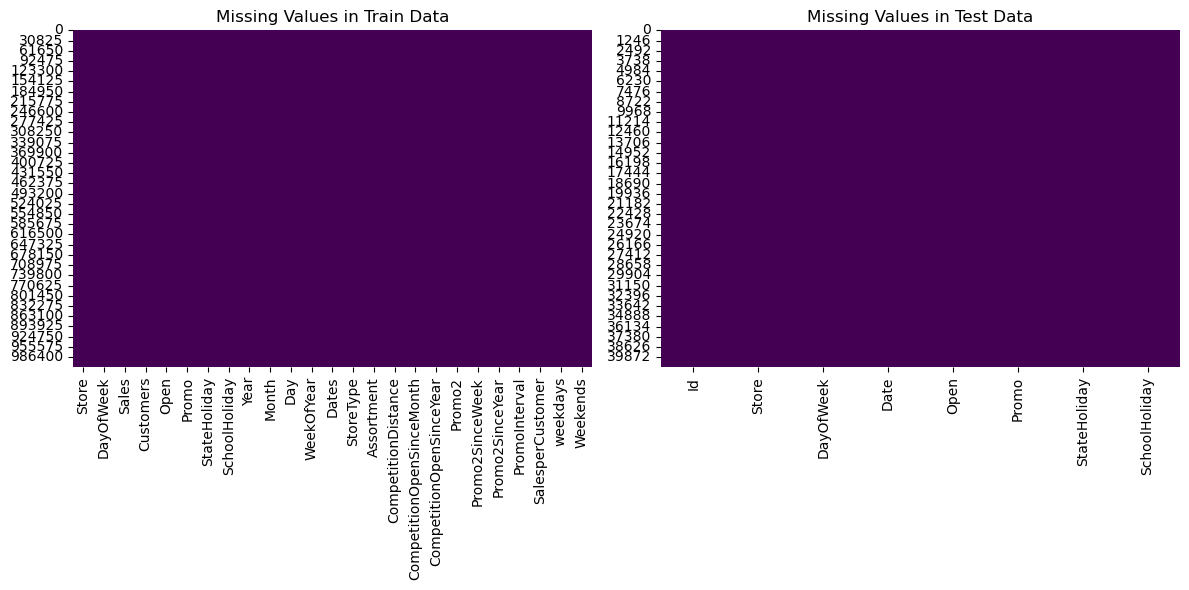

In [9]:
fig,axes=plt.subplots(1,2,figsize=(12,6))

sns.heatmap(train_null,cbar=False,cmap='viridis',ax=axes[0])
axes[0].set_title('Missing Values in Train Data')

sns.heatmap(test_null,cbar=False,cmap='viridis',ax=axes[1])
axes[1].set_title('Missing Values in Test Data')

plt.tight_layout()
plt.show()

#### In above graph you can clearly see that there is no missing values in both the dataframe

In [10]:
#coverting Date datatype from object to datetime
train_df['Dates']=pd.to_datetime(train_df['Dates'])

In [11]:
test_df['Date']=pd.to_datetime(test_df['Date'])

In [12]:
train_df['Dates'].dtypes

dtype('<M8[ns]')

## Model Building

According to task we need to build Long Short Term Memory which is a type of Recurrent Neural Network but we will bulid 3 model 

* 1. DNNs
* 2. RNNs
* 3. LSTM

### Steps in the process
* Preprocessing
* Define neural network shape and Model Compilation
* Fit Model
* Evaluation
* Visualize prediction

### Model 1: DNN

* A deep neural network (DNN) is an artificial neural network (ANN) with multiple layers between the input and output layers
* How to apply DNN for time-series data? The key idea here: we consider time-series as linear model

### Step 1: Data Preprocessing

Import a helper function of convert2matrix to reshape dataset in order to create 2-D input shape of DNN. A full connected net — the main difference between RNN or LTSM

In [13]:
sales_DN = train_df[["Dates", "Sales"]].set_index('Dates')

In [14]:
sales_DN.head()

,Sales
Dates,
2015-07-31,5263.0
2015-07-30,5020.0
2015-07-29,4782.0
2015-07-28,5011.0
2015-07-27,6102.0


In [15]:
sales_DN.shape

(1017209, 1)

In [16]:
# matrix
def convert2matrix(data_arr, look_back):
    X,Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

#### Split data set into testing dataset and train dataset

In [17]:
train_size=2000
train,test=sales_DN.values[0:train_size],sales_DN.values[train_size:len(sales_DN.values):]


In [18]:
#setup look back window
look_back=30
#convert dataset into right shape in order to input into the DNN
train_X, train_y = convert2matrix(train, look_back)
test_X, test_y = convert2matrix(test, look_back)

In [19]:
train_X.shape, train_y.shape,test_X.shape,test_y.shape

((1970, 30), (1970,), (1015179, 30), (1015179,))

### Step 2: Define neural network shape and compile model

In [26]:
from keras.models import Sequential
from keras.layers import Dense , Dropout
def model_dnn(look_back):
    model=Sequential()
    model.add(Dense(units=5, input_dim=look_back, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

### Step 3: Fit Model

In [27]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, SimpleRNN

In [28]:
trainX = train_X.astype(int)
trainY = train_y.astype(int)
testX = test_X.astype(int)
testY = test_y.astype(int)

In [29]:
mlflow.set_experiment("DNN")
mlflow.tensorflow.autolog()

In [30]:
model=model_dnn(look_back)

In [31]:
# Train the model with dropout
history = model.fit(trainX, trainY, epochs=100, batch_size=30, verbose=1,
                    validation_data=(testX, testY),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    shuffle=False)

2024/01/28 14:18:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6ec43b35b5444c03837472f35639695f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
66/66 [==============================] - 147s 2s/step - loss: 31755828.0000 - mse: 31755828.0000 - mae: 4777.9033 - val_loss: 40578312.0000 - val_mse: 40578312.0000 - val_mae: 5470.9473
Epoch 2/100
66/66 [==============================] - 124s 2s/step - loss: 22907686.0000 - mse: 22907686.0000 - mae: 4162.6108 - val_loss: 40245736.0000 - val_mse: 40245736.0000 - val_mae: 5432.5850
Epoch 3/100
66/66 [==============================] - 129s 2s/step - loss: 22749090.0000 - mse: 22749090.0000 - mae: 4132.7622 - val_loss: 39796684.0000 - val_mse: 39796684.0000 - val_mae: 5399.3354
Epoch 4/100
66/66 [==============================] - 124s 2s/step - loss: 22477238.0000 - mse: 22477236.0000 - mae: 4113.0454 - val_loss: 38991920.0000 - val_mse: 38991920.0000 - val_mae: 5343.1919
Epoch 5/100
66/66 [==============================] - 138s 2s/step - loss: 22330018.0000 - mse: 22330018.0000 - mae: 4093.3345 - val_loss: 38453344.0000 - val_mse: 38453344.0000 - val_mae: 5303.9062
Epoch 6/10

INFO:tensorflow:Assets written to: C:\Users\Sanket\AppData\Local\Temp\tmp85p9yn89\model\data\model\assets


In [32]:
from time import gmtime, strftime
time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model.save(f'../models/sales_DN-{time}.pkl')

INFO:tensorflow:Assets written to: ../models/sales_DN-2024-01-28-10-01-08.pkl\assets


INFO:tensorflow:Assets written to: ../models/sales_DN-2024-01-28-10-01-08.pkl\assets


### Step 4: Model evaluation

In [33]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

31725/31725 [==============================] - 90s 3ms/step
Train Root Mean Squared Error(RMSE): 3233.14; Train Mean Absolute Error(MAE) : 2813.56 
Test Root Mean Squared Error(RMSE): 4367.02; Test Mean Absolute Error(MAE) : 3718.73 


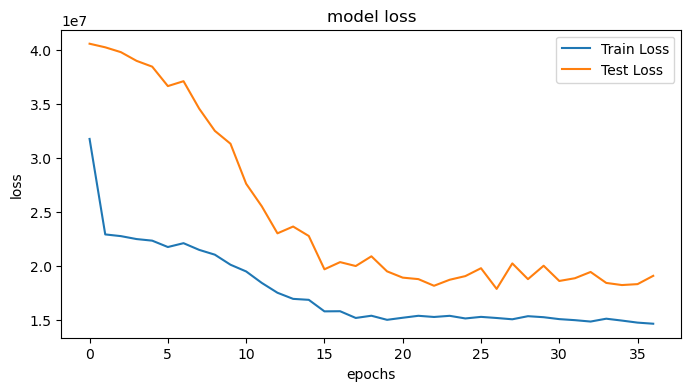

In [34]:
train_score = model.evaluate(trainX, trainY, verbose=0)
test_predict = model.predict(testX)

print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

### Step 5. Visualizing Prediction

In [35]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Dates', size=15)
    plt.legend(fontsize=15)
    plt.show();

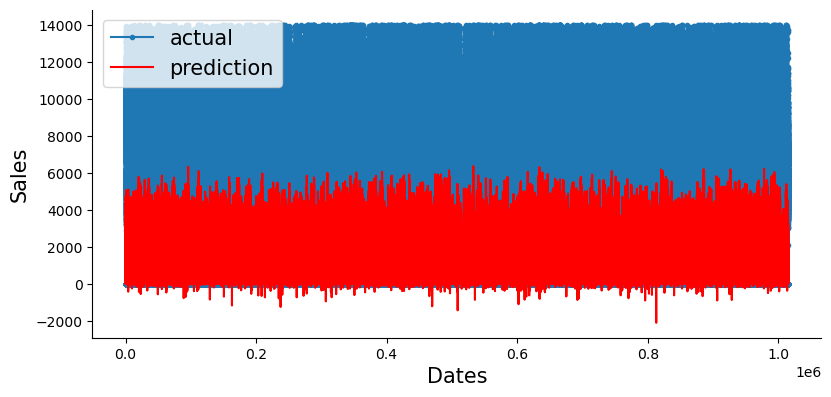

In [36]:
prediction_plot(testY, test_predict)

From the plot, even though it misses some peaks and troughs, but it’s able to capture the overall trends and seasonality without any parameter tuning or normalization preprocessing.

## Model 2: RNN

RNN(Recurrent Neural Network) handles sequences which is different from a fully connected DNN showed previously.

The key idea here: time-series datasets are sequences.

### Step 1: Data Preprocessing
* RNN input shape: (batch_size, window size, input_features)
* scalling

In [37]:
sales_rnn = train_df[['Dates', 'Sales']].set_index('Dates')

In [38]:
sales_rnn.head(1)

,Sales
Dates,
2015-07-31,5263.0


In [39]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [40]:
train_size = 40000
train,test = sales_rnn.values[0:train_size,:], sales_rnn.values[train_size:len(sales_rnn.values),:]
look_back = 30 #create window size as look_back=30
test = np.append(test,np.repeat(test[-1,], look_back))
train = np.append(train,np.repeat(train[-1,],look_back))
trainX,trainY =convert2matrix(train,look_back)
testX,testY =convert2matrix(test, look_back)
# reshape input to be [samples, window size, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


### Step 2: Define neural network shape and compile model
Built a RNN model with two hidden layers.

In [41]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping
def model_rnn(look_back):
    model=Sequential()
    model.add(SimpleRNN(units=32, input_shape=(1,look_back), activation="relu"))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

### Step 3: Fit Model

In [42]:
model=model_rnn(look_back)

history=model.fit(trainX,trainY, epochs=10, batch_size=30, verbose=1, validation_data=(testX,testY),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)

2024/01/28 15:34:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6c9fd0f82761445bafa23908e889544d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
   1/1334 [..............................] - ETA: 1:17:41 - loss: 4310174.5000 - mse: 4310174.5000 - mae: 1788.9790WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0030s vs `on_train_batch_end` time: 0.0083s). Check your callbacks.


1334/1334 [==============================] - 103s 75ms/step - loss: 3416537.7500 - mse: 3416537.7500 - mae: 1194.0612 - val_loss: 3167528.7500 - val_mse: 3167528.7500 - val_mae: 1108.7758
Epoch 2/10
1334/1334 [==============================] - 102s 76ms/step - loss: 2901191.5000 - mse: 2901191.5000 - mae: 1062.0566 - val_loss: 2985706.2500 - val_mse: 2985706.2500 - val_mae: 1056.1003
Epoch 3/10
1334/1334 [==============================] - 94s 70ms/step - loss: 2748389.0000 - mse: 2748389.0000 - mae: 1027.1014 - val_loss: 2876707.7500 - val_mse: 2876707.7500 - val_mae: 1031.4819
Epoch 4/10
1334/1334 [==============================] - 94s 71ms/step - loss: 2625796.0000 - mse: 2625796.0000 - mae: 1002.4171 - val_loss: 2791590.2500 - val_mse: 2791590.2500 - val_mae: 1020.7826
Epoch 5/10
1334/1334 [==============================] - 104s 78ms/step - loss: 2531278.7500 - mse: 2531278.7500 - mae: 984.8802 - val_loss: 2730263.2500 - val_mse: 2730263.2500 - val_mae: 1007.5167
Epoch 6/10
1334/133

INFO:tensorflow:Assets written to: C:\Users\Sanket\AppData\Local\Temp\tmp515ykvuu\model\data\model\assets


In [43]:
# saving model
time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model.save(f'../models/sales_rnn-{time}.pkl')

INFO:tensorflow:Assets written to: ../models/sales_rnn-2024-01-28-10-21-29.pkl\assets


INFO:tensorflow:Assets written to: ../models/sales_rnn-2024-01-28-10-21-29.pkl\assets


## Step 4: Model Evaluation
Print out error metrics and generate model loss plot.

30538/30538 [==============================] - 94s 3ms/step
Train Root Mean Squared Error(RMSE): 1494.67; train Mean Absolute Error(MAE) : 926.40 
Test Root Mean Squared Error(RMSE): 1578.56; test Mean Absolute Error(MAE) : 964.44 


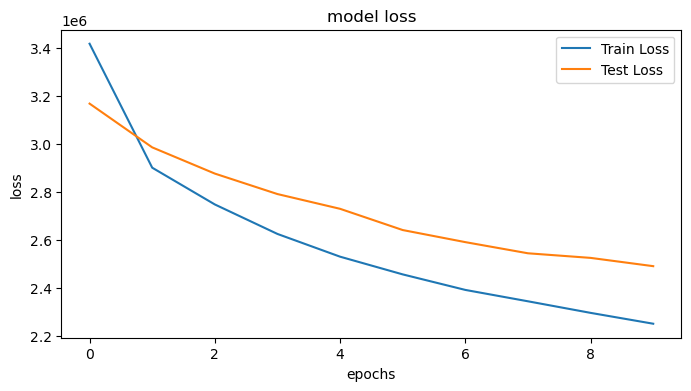

In [44]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
print('Train Root Mean Squared Error(RMSE): %.2f; train Mean Absolute Error(MAE) : %.2f '
      % (np.sqrt(mean_squared_error(trainY, train_predict[:,0])), mean_absolute_error(trainY, train_predict[:,0])))
print('Test Root Mean Squared Error(RMSE): %.2f; test Mean Absolute Error(MAE) : %.2f ' 
      % (np.sqrt(mean_squared_error(testY, test_predict[:,0])), mean_absolute_error(testY, test_predict[:,0])))
model_loss(history)

### Step 5. Visualizing Prediction

In [45]:
def prediction_plot(testY, test_predict, look_back):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Dates', size=15)
    plt.legend(fontsize=15)
    plt.show();

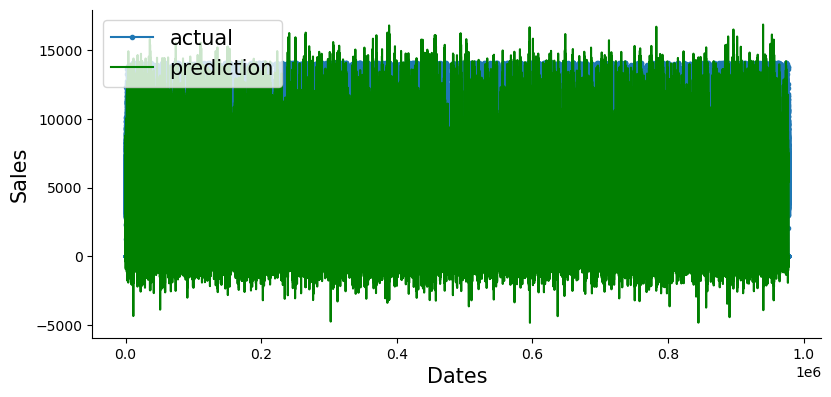

In [46]:
prediction_plot(testY, test_predict, look_back)

In general, the prediction looks good with a smaller test errors. Even though it misses some peaks and troughs, but it’s able to capture the overall trends and seasonality.

## Model 3: LSTM — one member of RNN families
LSTM(Long short-term memory), constructed by four main components: Input Gate, Output Gate, Memory Cell and Forget Gate

In [13]:
import warnings
import pickle
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

### Step1: Data Preprocessing:
LSTMs are sensitive to the scale of the input data. During the Preprocessing step, I applied MinMaxScaler preprocessing class from the scikit-learn module to normalize/rescale dataset.

In [14]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [15]:
sales_lstm = train_df[["Dates", "Sales"]].set_index('Dates')

In [16]:
#sales.dtypes
scaler = MinMaxScaler()
scaler.fit(sales_lstm.Sales.values.reshape([-1, 1]))
SalesScaled = scaler.transform(sales_lstm.Sales.values.reshape(-1, 1))
sales_lstm['SalesScaled'] = SalesScaled
sales_lstm.head(5)

,Sales,SalesScaled
Dates,,
2015-07-31,5263.0,0.374617
2015-07-30,5020.0,0.357321
2015-07-29,4782.0,0.340380
2015-07-28,5011.0,0.356680
2015-07-27,6102.0,0.434337


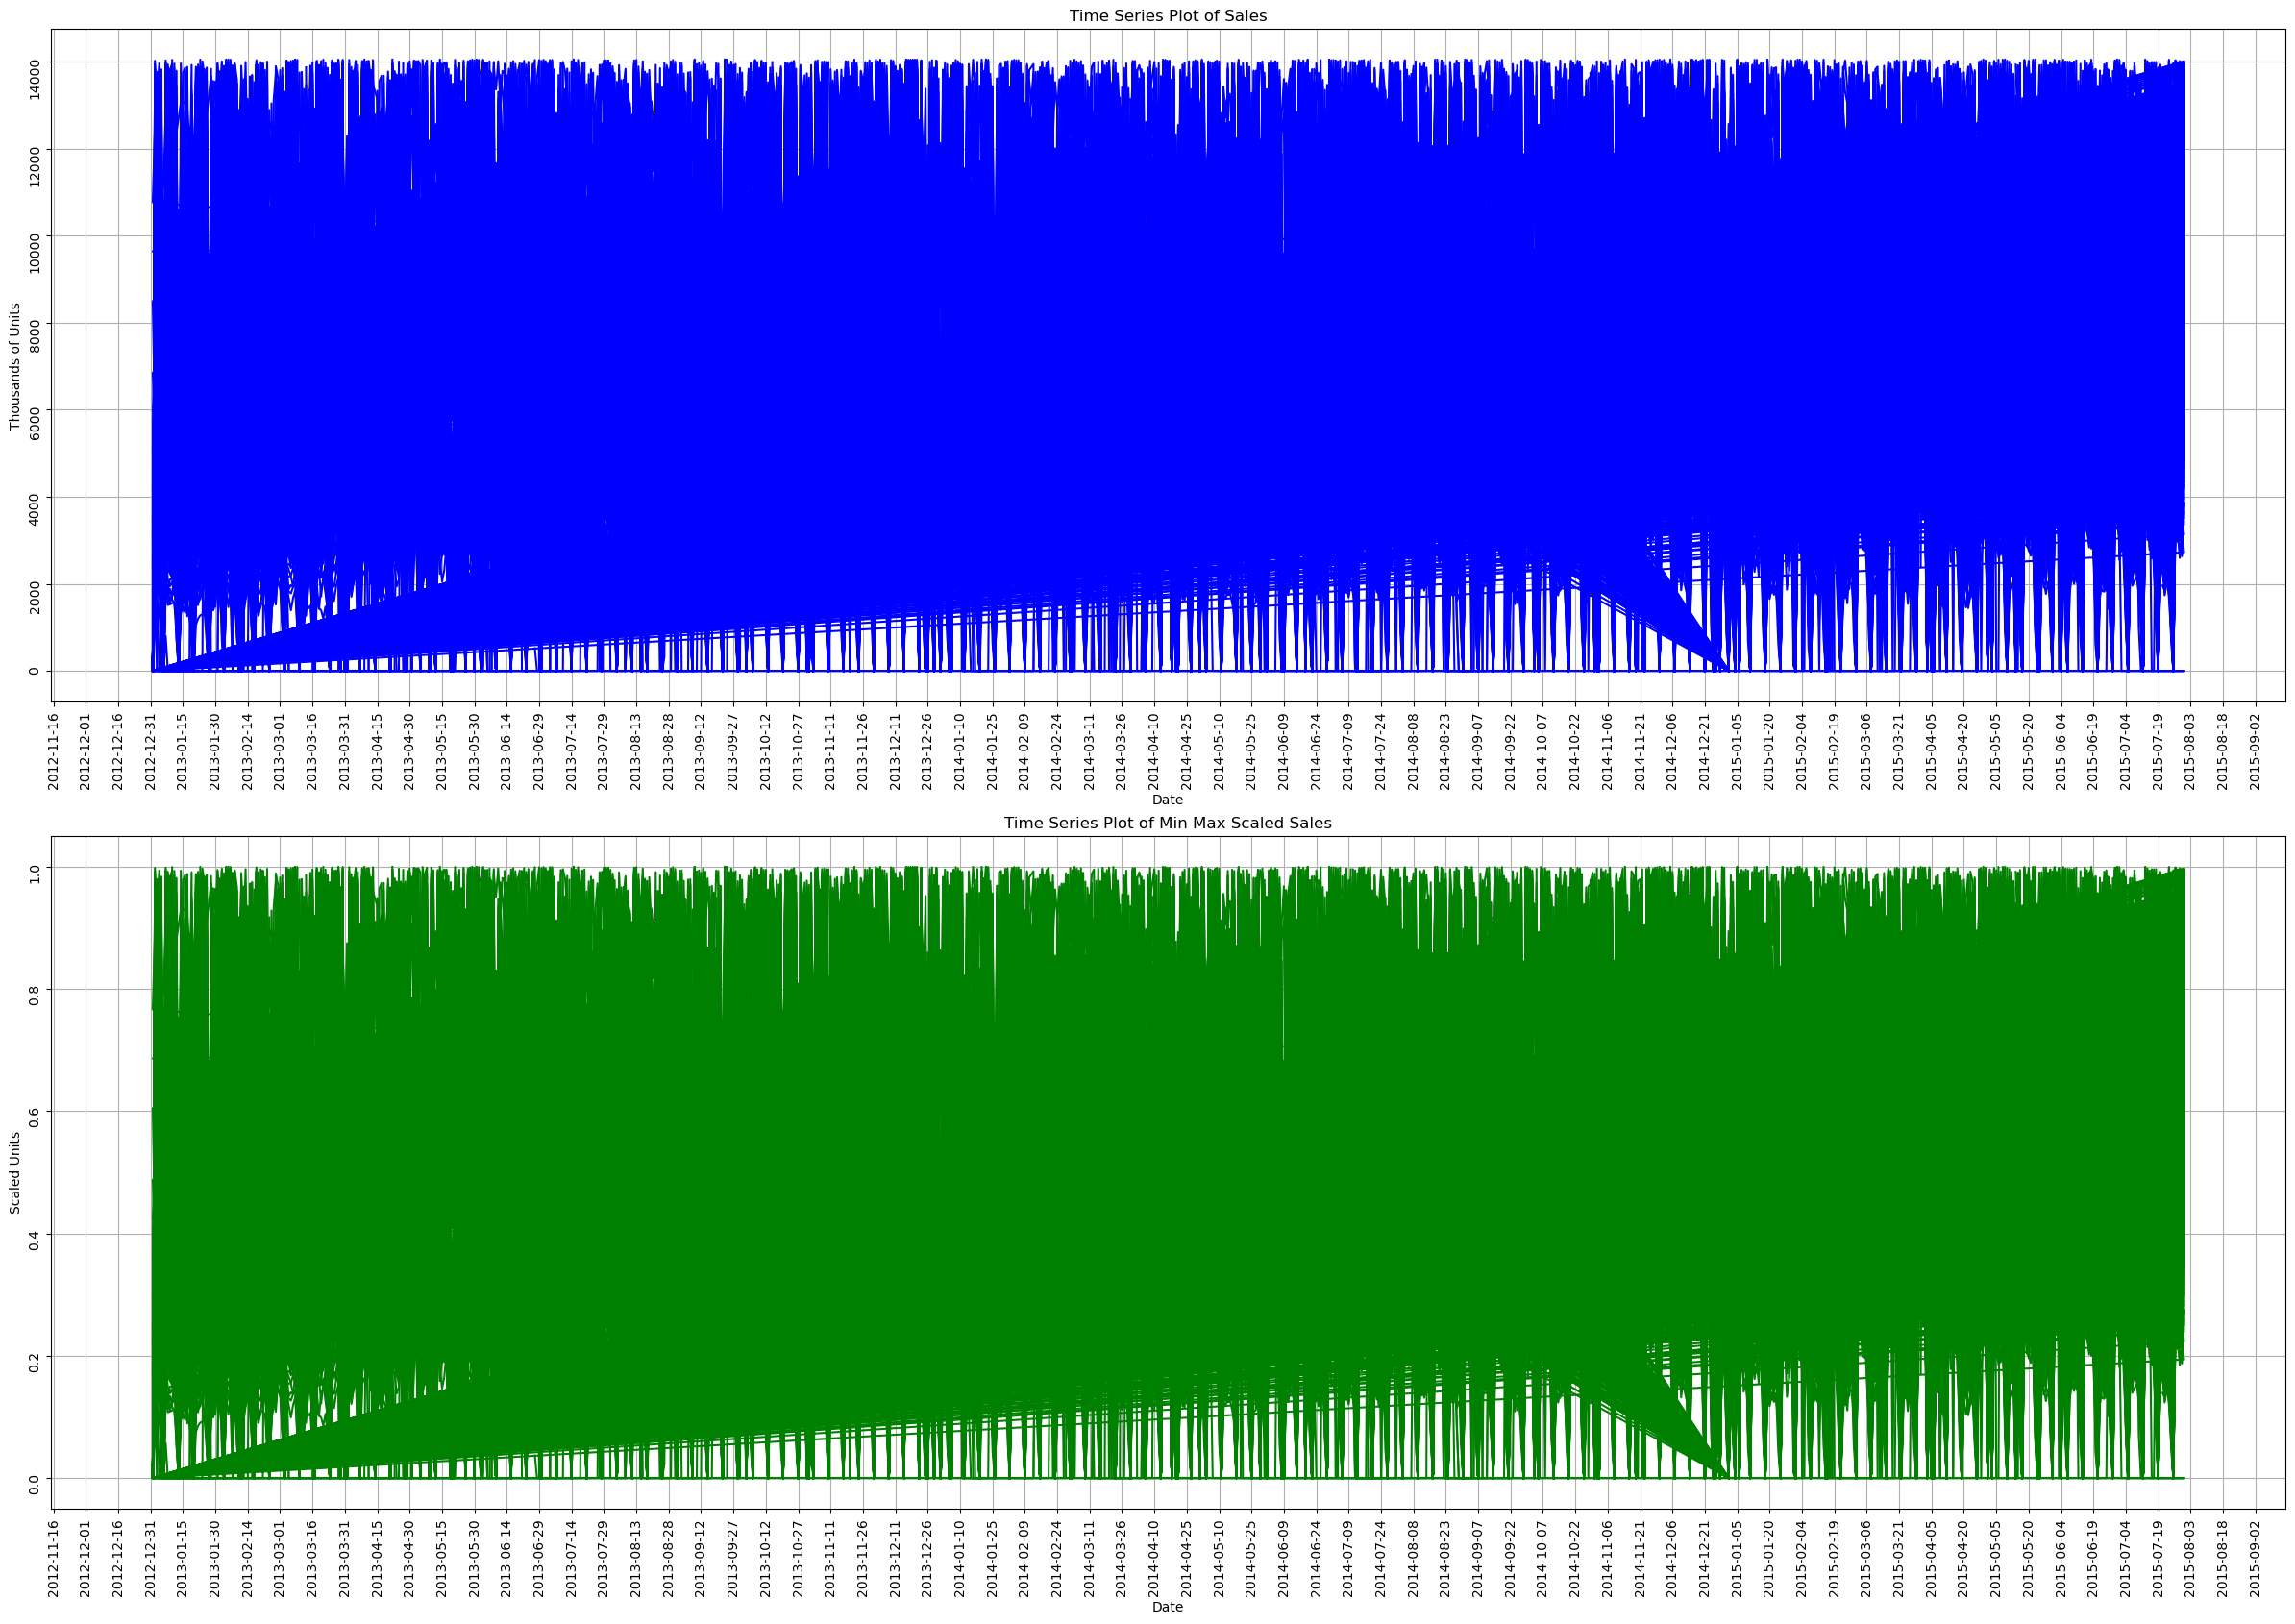

In [17]:
plt.rcParams['agg.path.chunksize'] = 200
plt.rcParams['path.simplify_threshold'] = 1.0

fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(sales_lstm.index, sales_lstm.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(sales_lstm.index, sales_lstm.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Sales')
ax2.grid(True)

plt.show()


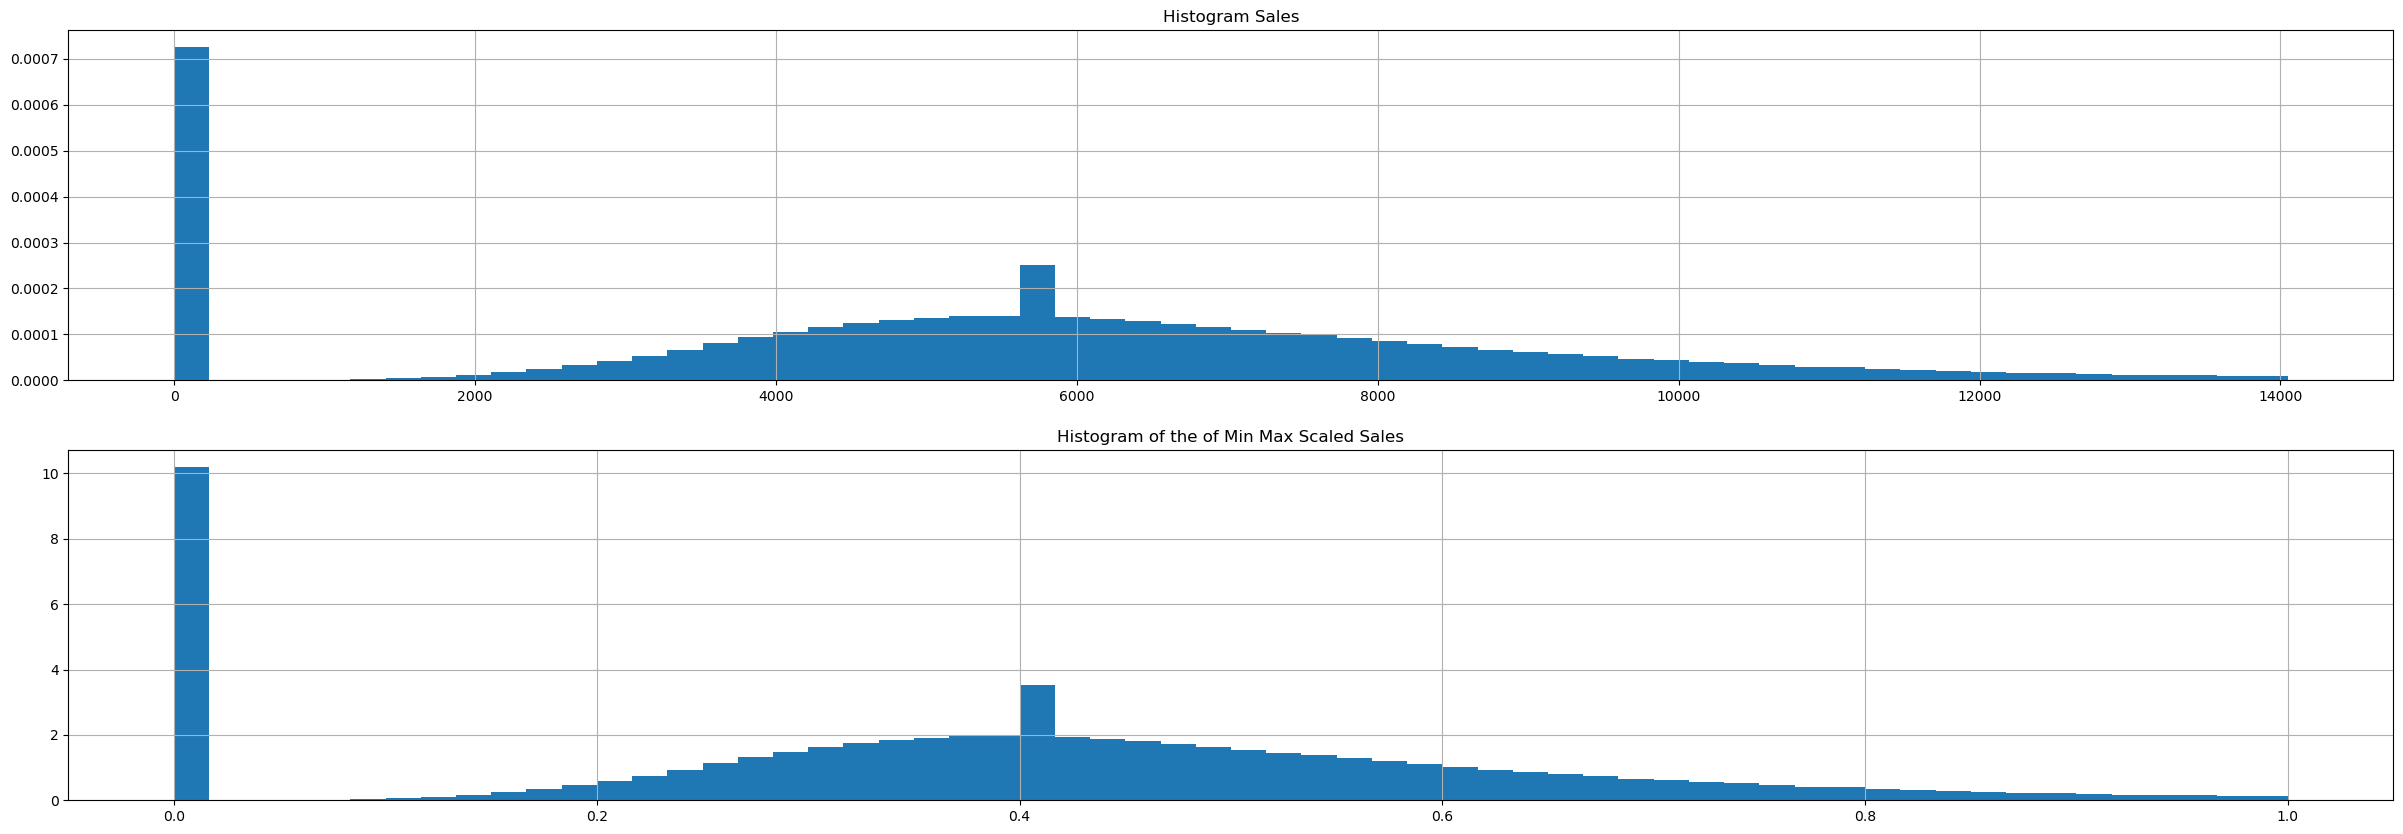

In [18]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(sales_lstm.Sales, density=True, bins=60)
ax1.title.set_text('Histogram Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(sales_lstm.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Sales')
ax2.grid(True)
plt.show()

## Check whether the time Series Data is Stationary
Unit Root Tests helps us determine the stationarity of our data

In [17]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

In [18]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray
df_arr= sales_lstm.values 
#sales_lstm.values = df_arr.astype('float32')
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

In [19]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

salesScaledDiff = difference(sales_lstm.SalesScaled.values)
salesScaledDiff

0         -0.017297
1         -0.016941
2          0.016300
3          0.077657
4         -0.434337
             ...   
1017203    0.339597
1017204   -0.016442
1017205   -0.017297
1017206   -0.042708
1017207   -0.263150
Length: 1017208, dtype: float64

In [20]:
acfSalesScaled = acf(sales_lstm.SalesScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

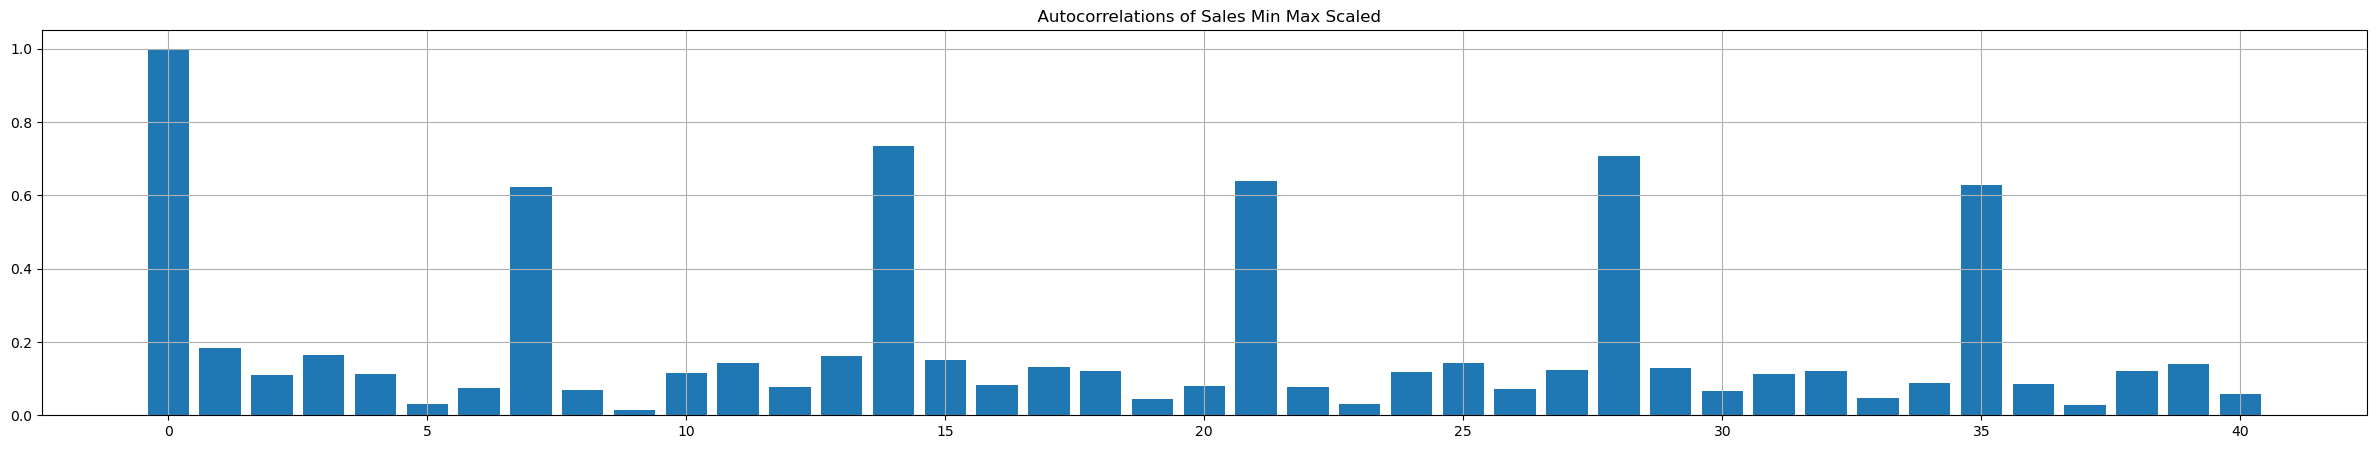

In [21]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()
corrPlots(acfSalesScaledNp, '')

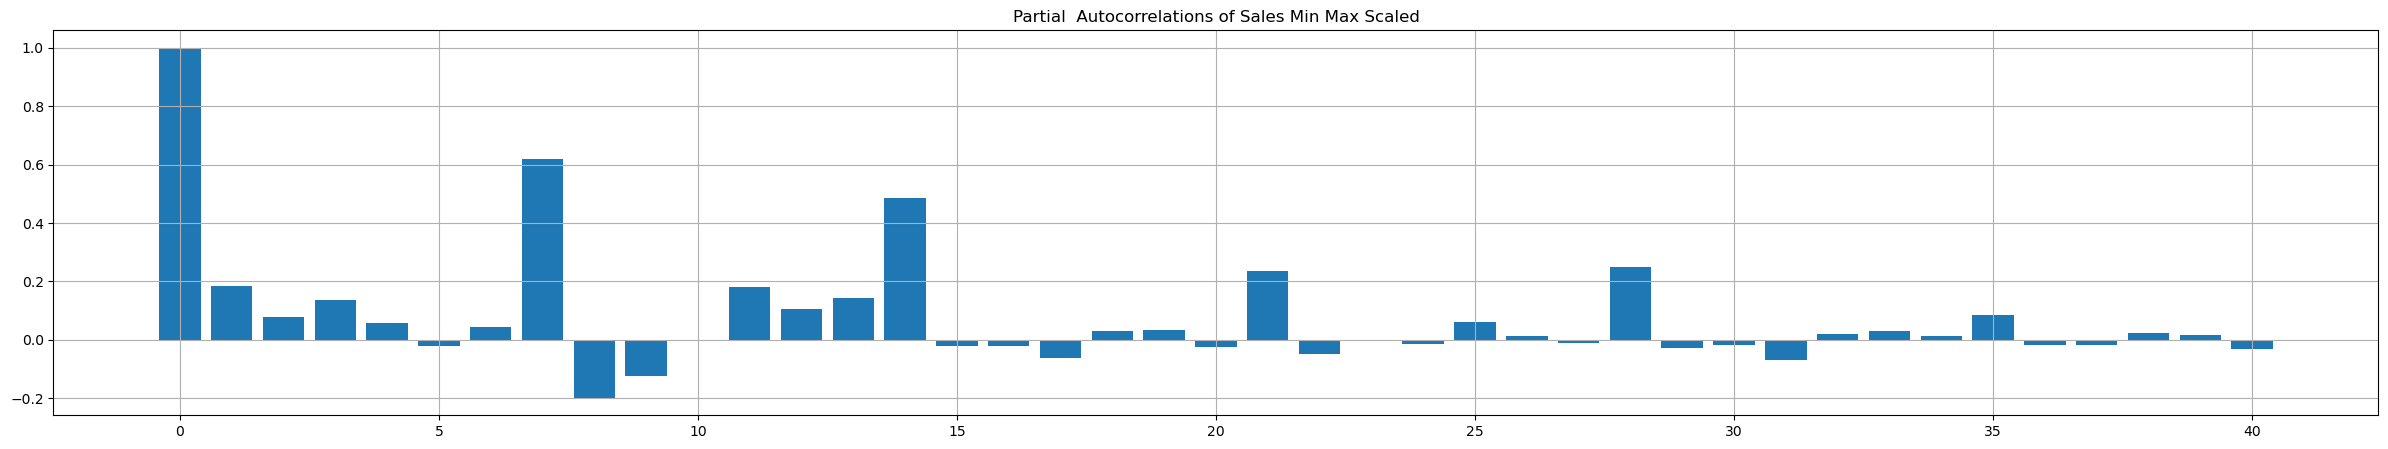

In [22]:
pacfSalesScaled = pacf(sales_lstm.SalesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)
corrPlots(pacfSalesScaledNp, "Partial")

### Split dataset into training and test dataset. Create input 3-D input shape for LSTM.

In [23]:
train_size = 40000
test_size = len(df_arr) - train_size
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
look_back = 30
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Step 2: Define neural network shape and compile model
Here, a very simple two-layer LTSM without hidden layers

In [24]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
def model_lstm(look_back):
    model=Sequential()
    model.add(LSTM(100, input_shape=(1, look_back), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

In [25]:
trainX.shape , trainY.shape

((39970, 1, 30), (39970, 1))

### Step 3: Fit model

In [26]:
model=model_lstm(look_back)

history = model.fit(trainX, trainY, epochs=10, batch_size=30, 
                    validation_data=(testX, testY), callbacks=[EarlyStopping(monitor='val_loss', 
                                                                             patience=10)], verbose=1, shuffle=False)



Epoch 1/10


1333/1333 [==============================] - 282s 205ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0456 - val_loss: 0.0155 - val_mse: 0.0155 - val_mae: 0.0731
Epoch 2/10
1333/1333 [==============================] - 249s 187ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0371 - val_loss: 0.0156 - val_mse: 0.0156 - val_mae: 0.0707
Epoch 3/10
1333/1333 [==============================] - 259s 194ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0358 - val_loss: 0.0157 - val_mse: 0.0157 - val_mae: 0.0692
Epoch 4/10
1333/1333 [==============================] - 236s 177ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0346 - val_loss: 0.0149 - val_mse: 0.0149 - val_mae: 0.0664
Epoch 5/10
1333/1333 [==============================] - 248s 186ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0336 - val_loss: 0.0144 - val_mse: 0.0144 - val_mae: 0.0654
Epoch 6/10
1333/1333 [==============================] - 250s 187ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0328 - val_loss: 0.0141 - val_mse: 0

In [27]:
trainY_2d = trainY.reshape(-1, 1)
testY_2d = testY.reshape(-1, 1)


In [28]:
print("trainY_2d shape:", trainY_2d.shape)
print("testY_2d shape:", testY_2d.shape)

trainY_2d shape: (39970, 1)
testY_2d shape: (1994388, 1)


## Step 4: Model Evaluation
Print out error metrics and generate model loss plot.

In [29]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY_inverted = scaler.inverse_transform(trainY_2d.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
testY_inverted = scaler.inverse_transform(testY_2d.reshape(-1, 1))

print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE): %.2f' % (
    np.sqrt(mean_squared_error(trainY_2d, train_predict)),
    mean_absolute_error(trainY_2d, train_predict)
))

print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE): %.2f' % (
    np.sqrt(mean_squared_error(testY_2d, test_predict)),
    mean_absolute_error(testY_2d, test_predict)
))


62325/62325 [==============================] - 277s 4ms/step
Train Root Mean Squared Error(RMSE): 3406.80; Train Mean Absolute Error(MAE): 2206.12
Test Root Mean Squared Error(RMSE): 3480.33; Test Mean Absolute Error(MAE): 2263.06


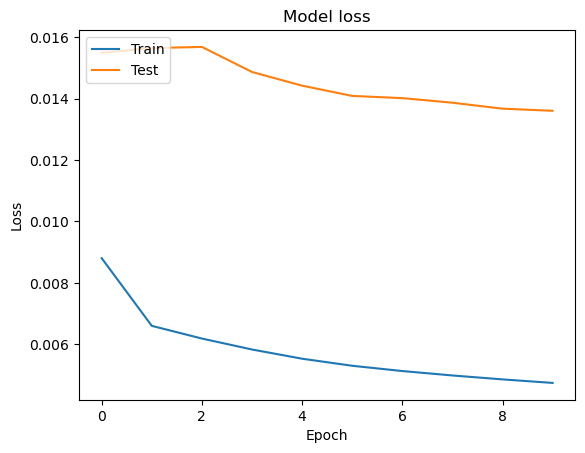

In [30]:
import matplotlib.pyplot as plt

def model_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Call the model_loss function with your 'history' object
model_loss(history)


### 5. Visualization


In [31]:
def prediction_plots(testY, test_predict, look_back):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Dates', size=15)
    plt.legend(fontsize=15)
    plt.show();

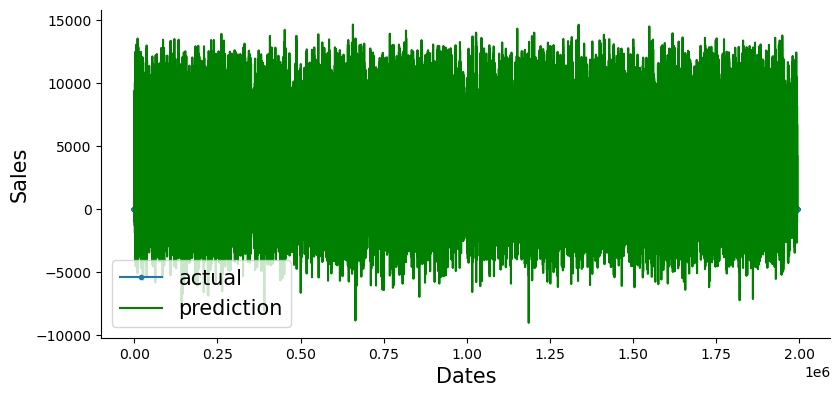

In [32]:
prediction_plots(testY_2d, test_predict, 5)

In [33]:
# saving model
from time import strftime, gmtime

# Assuming 'model' is your trained model
time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model.save(f'E:/Pharmaceutical Code/{time}_LSTM_model.pkl')


INFO:tensorflow:Assets written to: E:/Pharmaceutical Code/2024-02-03-11-44-42_LSTM_model.pkl\assets


INFO:tensorflow:Assets written to: E:/Pharmaceutical Code/2024-02-03-11-44-42_LSTM_model.pkl\assets


In [42]:
import mlflow.keras
from keras.callbacks import EarlyStopping


In [43]:
# Log the model with MLflow
with mlflow.start_run():
    mlflow.log_param("learning_rate", 0.001)
    
    # Log other metrics
    mlflow.log_metric("train_loss", history.history['loss'][-1])
    mlflow.log_metric("val_loss", history.history['val_loss'][-1])
    mlflow.log_metric("train_mse", history.history['mse'][-1])
    mlflow.log_metric("val_mse", history.history['val_mse'][-1])
    mlflow.log_metric("train_mae", history.history['mae'][-1])
    mlflow.log_metric("val_mae", history.history['val_mae'][-1])


    # Log the model
    mlflow.keras.log_model(model, "model")

2024/02/03 17:36:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Sanket\AppData\Local\Temp\tmpudan_kp6\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Sanket\AppData\Local\Temp\tmpudan_kp6\model\data\model\assets


In [45]:
 mlflow.log_artifact("E:\\models\\sales_LSTM-{time}.pkl")